In [1]:
import pandas as pd

import glob

from pathlib import Path
import csv

import os
import requests
import json

import quandl
from iexfinance.stocks import Stock

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [3]:
## Constants 

## Set start date variable - dataframes will be created starting from this date
start_date = '2020-01-01'
end_date = '2021-10-14'
default_date_range = '2y' ## Default Range for IEX functions - don't need more at the moment

In [4]:
## Import FTD File and Symbol List using Pickle 
# ftd_df = load_obj('AnalysisResources/analysis_ftd_all_data.pkl')
# symbol_df = load_obj('AnalysisResources/analysis_symbol_all_list.pkl')


## Import FTD File using CSV 
ftd_df = pd.read_csv(
    Path('AnalysisResources/analysis_ftd_all_data.csv'),
    index_col=0, parse_dates=True
)

## Import Symbol and CUSIP list using CSV
symbol_df = pd.read_csv(
    Path('AnalysisResources/analysis_symbol_all_list.csv'),
    index_col=0
)

In [23]:
## QUANDL/NASDAQ 
nsdq_api_key = os.environ.get('NASDAQ_API_KEY')
base_url_nsdq = 'https://data.nasdaq.com/api/v3/datasets/FINRA/'

## Test iexcloud setup and stability 
iex_token = os.getenv("IEX_TOKEN")
iex_api_ver = os.getenv("IEX_API_VERSION")
iex_out_form = os.getenv("IEX_OUTPUT_FORMAT")

## Print output form from iexfinance library and API 
## print(iex_out_form)

base_url_iex = 'https://cloud.iexapis.com/stable/'
# sandbox_url = 'https://sandbox.iexapis.com/stable/'

## IEX Status Test 
test_resp = requests.get(base_url_iex + 'status')
test_resp

<Response [200]>

In [24]:
## Check for Real vs Sandbox - throw error if Real 
## Check sandbox vs stable 
if iex_api_ver == 'stable':
    print(error_variable)                  ## This file isn't meant for Real Calls at-the-moment 
elif iex_api_ver == 'iexcloud-sandbox':
    print('iexcloud-sandbox TESTING')
else:
    print('PROBLEM')

iexcloud-sandbox TESTING


In [6]:
def get_sorted_short_data_QUANDL(symbol):
    string_nsdq = "FINRA/FNSQ_"+symbol
    string_nyse = "FINRA/FNYX_"+symbol
    
    df1 = quandl.get(string_nsdq,start_date=start_date,end_date=end_date,authtoken=nsdq_api_key)   ## Nasdaq
    df2 = quandl.get(string_nyse,start_date=start_date,end_date=end_date,authtoken=nsdq_api_key)   ## NYSE

    df1 = df1.rename(columns={'ShortVolume':'ShortVolumeNSDQ','TotalVolume':'TotalVolumeNSDQ'})
    df1 = df1.drop(columns={'ShortExemptVolume'})

    df2 = df2.rename(columns={'ShortVolume':'ShortVolumeNYSE','TotalVolume':'TotalVolumeNYSE'})
    df2 = df2.drop(columns={'ShortExemptVolume'})

    df3 = pd.merge(df1,df2,on='Date',how='outer')

    df3['TotalShortVolume'] = df3['ShortVolumeNSDQ'] + df3['ShortVolumeNYSE']
    df3['TotalVolume'] = df3['TotalVolumeNSDQ'] + df3['TotalVolumeNYSE']
    df3['SHORToverTOTALvolume'] = df3['TotalShortVolume'] / df3['TotalVolume'] * 100
    short_df = df3[['TotalShortVolume','TotalVolume','SHORToverTOTALvolume']]
    return short_df

def get_short_data_QUANDL(symbol):
    string_nsdq = "FINRA/FNSQ_"+symbol
    string_nyse = "FINRA/FNYX_"+symbol
    
    df1 = quandl.get(string_nsdq,start_date=start_date,end_date=end_date,authtoken=nsdq_api_key)   ## Nasdaq
    df2 = quandl.get(string_nyse,start_date=start_date,end_date=end_date,authtoken=nsdq_api_key)   ## NYSE

    df1 = df1.rename(columns={'ShortVolume':'ShortVolumeNSDQ','TotalVolume':'TotalVolumeNSDQ'})
    #df1 = df1.drop(columns={'ShortExemptVolume'})
    df1 = df1.rename(columns={'ShortExemptVolume':'ShortExemptVolumeNSDQ'})

    df2 = df2.rename(columns={'ShortVolume':'ShortVolumeNYSE','TotalVolume':'TotalVolumeNYSE'})
    #df2 = df2.drop(columns={'ShortExemptVolume'})
    df2 = df2.rename(columns={'ShortExemptVolume':'ShortExemptVolumeNYSE'})

    df3 = pd.merge(df1,df2,on='Date',how='outer')
    
    return df3

In [7]:
def get_data_all(symbol):
    cusip_number = return_CUSIP_from_symbol(symbol)
    ftd_data = return_ftd_data_cusip(cusip_number)
    ftd_data = ftd_data.drop(columns={'SYMBOL'})
    iex_data = Stock(symbol).get_historical_prices(range=default_date_range,chartCloseOnly=True)
    iex_data = iex_data[start_date:end_date]
    iex_data.reset_index(inplace=True)
    iex_data.rename(columns={'index':'Date'},inplace=True)
    iex_data['Date'] = pd.to_datetime(iex_data['Date'])
    iex_data.set_index('Date',inplace=True)
    df1 = pd.merge(iex_data, ftd_data, on='Date',how='outer')
    df1['QUANTITY_FAILS'] = df1['QUANTITY_FAILS'].fillna(0)
    df2 = get_short_data_QUANDL(symbol)
    df = pd.merge(df1,df2,on='Date',how='outer')
    return df 

def return_ftd_data_cusip(cusip_number):
    df = ftd_df.copy()
    df = df.reset_index()
    df = df.set_index("CUSIP")
    df = df.loc[cusip_number]
    df = df.set_index('Date')
    return df

def return_CUSIP_from_symbol(symbol):
    new_symbol_df = pd.DataFrame(symbol_df)
    new_symbol_df.dropna(inplace=True)
    new_symbol_df.reset_index(inplace=True,drop=True)
    new_symbol_df.set_index('SYMBOL',inplace=True)
    cusip_variable = new_symbol_df.loc[symbol]
    cusip_variable = cusip_variable['CUSIP']
    return cusip_variable

In [8]:
gme_df = get_data_all('GME')

In [9]:
gme_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 451 entries, 2020-01-02 to 2021-10-14
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   close                  451 non-null    object 
 1   volume                 451 non-null    object 
 2   change                 451 non-null    object 
 3   changePercent          451 non-null    object 
 4   changeOverTime         451 non-null    object 
 5   QUANTITY_FAILS         451 non-null    float64
 6   ShortVolumeNSDQ        451 non-null    float64
 7   ShortExemptVolumeNSDQ  451 non-null    float64
 8   TotalVolumeNSDQ        451 non-null    float64
 9   ShortVolumeNYSE        451 non-null    float64
 10  ShortExemptVolumeNYSE  451 non-null    float64
 11  TotalVolumeNYSE        451 non-null    float64
dtypes: float64(7), object(5)
memory usage: 45.8+ KB


In [10]:
gme_df

,close,volume,change,changePercent,changeOverTime,QUANTITY_FAILS,ShortVolumeNSDQ,ShortExemptVolumeNSDQ,TotalVolumeNSDQ,ShortVolumeNYSE,ShortExemptVolumeNYSE,TotalVolumeNYSE
Date,,,,,,,,,,,,
2020-01-02,6.49,4599278,0.236458,0.0393,0.050091,10609.0,872127.0,8472.0,1185904.0,276386.0,2448.0,527414.0
2020-01-03,5.99,3714280,-0.442881,-0.0711,-0.023974,28692.0,520156.0,11999.0,832247.0,306258.0,2.0,506189.0
2020-01-06,5.96,3494818,-0.030506,-0.0053,-0.02842,28665.0,498788.0,20569.0,859426.0,198834.0,15.0,319375.0
2020-01-07,5.66,5329018,-0.33319,-0.0579,-0.086579,0.0,604854.0,6372.0,1908324.0,351972.0,991.0,523321.0
2020-01-08,5.73,5781720,0.205833,0.037,-0.051149,7039.0,746989.0,26168.0,1480915.0,529867.0,28.0,852908.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,178.52,848750,0.562107,0.0034,27.784816,3369.0,127261.0,1889.0,207559.0,22569.0,83.0,49483.0
2021-10-11,183.9,2809720,5.613582,0.0318,28.947157,0.0,442600.0,4696.0,711928.0,100482.0,163.0,280789.0
2021-10-12,179.44,1239682,-2.383031,-0.013,29.201772,43995.0,201231.0,428.0,331727.0,47431.0,5.0,100709.0


<AxesSubplot:title={'center':'GME Close Price'}, xlabel='Date'>

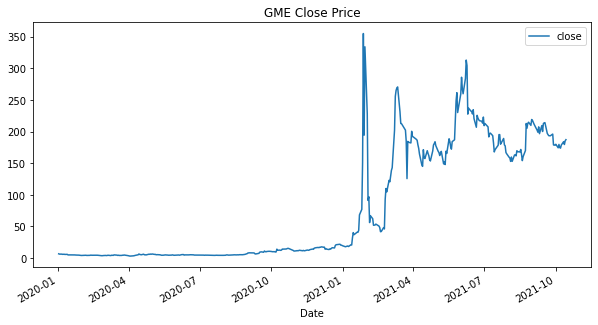

In [11]:
gme_df.close.plot(
    figsize=[10,5],
    title='GME Close Price',
    legend=True
)

In [12]:
## Prepare Data for Training and Testing
df = gme_df.copy()

df

,close,volume,change,changePercent,changeOverTime,QUANTITY_FAILS,ShortVolumeNSDQ,ShortExemptVolumeNSDQ,TotalVolumeNSDQ,ShortVolumeNYSE,ShortExemptVolumeNYSE,TotalVolumeNYSE
Date,,,,,,,,,,,,
2020-01-02,6.49,4599278,0.236458,0.0393,0.050091,10609.0,872127.0,8472.0,1185904.0,276386.0,2448.0,527414.0
2020-01-03,5.99,3714280,-0.442881,-0.0711,-0.023974,28692.0,520156.0,11999.0,832247.0,306258.0,2.0,506189.0
2020-01-06,5.96,3494818,-0.030506,-0.0053,-0.02842,28665.0,498788.0,20569.0,859426.0,198834.0,15.0,319375.0
2020-01-07,5.66,5329018,-0.33319,-0.0579,-0.086579,0.0,604854.0,6372.0,1908324.0,351972.0,991.0,523321.0
2020-01-08,5.73,5781720,0.205833,0.037,-0.051149,7039.0,746989.0,26168.0,1480915.0,529867.0,28.0,852908.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,178.52,848750,0.562107,0.0034,27.784816,3369.0,127261.0,1889.0,207559.0,22569.0,83.0,49483.0
2021-10-11,183.9,2809720,5.613582,0.0318,28.947157,0.0,442600.0,4696.0,711928.0,100482.0,163.0,280789.0
2021-10-12,179.44,1239682,-2.383031,-0.013,29.201772,43995.0,201231.0,428.0,331727.0,47431.0,5.0,100709.0


In [13]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced

In [14]:
# Create features
X = df.drop(columns='close')

# Create target 
y = df['close'].to_frame()

X.describe()

,QUANTITY_FAILS,ShortVolumeNSDQ,ShortExemptVolumeNSDQ,TotalVolumeNSDQ,ShortVolumeNYSE,ShortExemptVolumeNYSE,TotalVolumeNYSE
count,4.510000e+02,4.510000e+02,451.000000,4.510000e+02,4.510000e+02,451.000000,4.510000e+02
mean,2.229190e+05,1.802584e+06,54273.050998,3.626889e+06,6.385112e+05,10040.066519,1.414989e+06
std,4.062070e+05,3.410843e+06,118228.444236,7.382333e+06,1.270081e+06,40438.703073,3.029835e+06
min,0.000000e+00,1.009040e+05,0.000000,2.075590e+05,1.768700e+04,0.000000,4.948300e+04
25%,8.751500e+03,3.919370e+05,4472.500000,7.576720e+05,1.090560e+05,0.000000,2.494190e+05
50%,4.248100e+04,7.049260e+05,17193.000000,1.344994e+06,2.075960e+05,0.000000,4.600950e+05
75%,2.680780e+05,1.517290e+06,42914.500000,3.017456e+06,5.358545e+05,457.500000,1.157784e+06
max,3.210148e+06,3.289018e+07,894803.000000,6.983814e+07,1.282189e+07,439772.000000,2.665732e+07


In [15]:
# Check the balance of our target values
y['close'].value_counts()

3.70      4
4.97      4
4.27      4
4.17      4
4.28      4
         ..
218.72    1
217.08    1
216.29    1
209.28    1
14.31     1
Name: close, Length: 395, dtype: int64

In [16]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    #stratify=y  ## Stratify doesn't work if set to 'y'
                                                   )
X_train.shape

 

(338, 11)

In [17]:
## Linear Regression
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(solver='lbfgs', random_state=1,)
# classifier.fit(X_train, y_train)

## Doesn't Work 

In [18]:
## Scaling
scaler = StandardScaler()

In [19]:
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
## Random Forest 
# rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
# rf_model = rf_model.fit(X_train_scaled, y_train)
# predictions = rf_model.predict(X_test_scaled)

## Doesn't work 

In [21]:
## Nothing at the moment works. Need to find or learn how to use different stats models to achieve what trying to do 